# Install pkgs

**Note:** This is training notebook only. Inference ain't included in . 
Anybody who wants to use this notebook for inference purposes is most welcome.

In [ ]:
import os
import shutil
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import zarr, copick
from tqdm import tqdm
import napari
import mlflow
import mlflow.pytorch
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.io.writers as write
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import gc
import concurrent.futures
import optuna, optunahub
import json
import copy
import random

gc.enable()

In [2]:
torch._dynamo.config.cache_size_limit = 64
torch.backends.cudnn.benchmark = True

In [3]:
path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/'
output_path = path + 'output/'

In [4]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 2,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 3,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 4,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 5,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],

    "overlay_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = path + "output/copick.config"
output_overlay = path + "output/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = path + 'train/overlay'
destination_dir = path + 'output/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-amylase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-amylase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/output/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied /media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to /media

# Prepare the dataset
## 1. Get copick root

In [5]:
root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
#tomo_type = "denoised"

## 2. Generate multi-class segmentation masks from picks, and saved them to the copick overlay directory (one-time)

In [6]:
root

CopickRoot(user_id=None, len(pickable_objects)=None, len(runs)=None) at 0x7b6f65b74f20

In [7]:
# Just do this once
generate_masks = True

if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        for tomogram in tomo.tomograms:
            tomo_type = tomogram.tomo_type
            if tomo_type != 'denoised':
                continue
            image = tomogram.numpy()
            target = np.zeros(image.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id='curation')
                if len(pick):
                    target = segmentation_from_picks.from_picks(pick[0],
                                                                target,
                                                                target_objects[pickable_object.name]['radius'],# * 0.5,
                                                                target_objects[pickable_object.name]['label']
                                                               )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|███████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


## 3. Get tomograms and their segmentaion masks (from picks) arrays

In [8]:
train_label_experiment_folders_path = '/media/max1024/Extreme SSD1/Kaggle/czii-cryo-et-object-identification/' + 'train/overlay/ExperimentRuns/'

In [9]:
class_ids = {
    'apo-ferritin': 1,
    'beta-galactosidase': 2,
    'ribosome': 3,
    'thyroglobulin': 4,
    'virus-like-particle': 5,
}

In [10]:
particle_radius = {
    'apo-ferritin': 60,
    'beta-galactosidase': 90,
    'ribosome': 150,
    'thyroglobulin': 130,
    'virus-like-particle': 135,
}

In [11]:
def create_labels_df(experiment):
    labels_dict = {}
    
    particle_types_dict = {}
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/apo-ferritin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['apo-ferritin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/beta-galactosidase.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['beta-galactosidase'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/ribosome.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['ribosome'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/thyroglobulin.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['thyroglobulin'] = loaded_json
    
    with open(f'{train_label_experiment_folders_path}{experiment}/Picks/virus-like-particle.json') as f:
        loaded_json = json.loads(f.read())
    particle_types_dict['virus-like-particle'] = loaded_json
    
    labels_dict[experiment] = particle_types_dict

    experiment_list = []
    particle_type_list = []
    x_list = []
    y_list = []
    z_list = []
    r_list = []
    class_id_list = []
    #print(experiment)
    #print(len(labels_dict[experiment]['apo-ferritin']['points']))
    #print(type(labels_dict[experiment]['apo-ferritin']['points']))
    #print(labels_dict[experiment]['apo-ferritin']['points'][0])

    for key in labels_dict[experiment].keys():
        #print(labels_dict[experiment][key])
        #print(labels_dict[experiment][key]['pickable_object_name'])
        for i in range(len(labels_dict[experiment][key]['points'])):
            experiment_list.append(labels_dict[experiment][key]['run_name'])
            particle_type_list.append(labels_dict[experiment][key]['pickable_object_name'])
            x_list.append(labels_dict[experiment][key]['points'][i]['location']['x']/10.012444537618887)
            y_list.append(labels_dict[experiment][key]['points'][i]['location']['y']/10.012444196428572)
            z_list.append(labels_dict[experiment][key]['points'][i]['location']['z']/10.012444196428572)
            r_list.append(particle_radius[key]/10)
            class_id_list.append(class_ids[key])

    labels_df = pd.DataFrame({'experiment':experiment_list, 'particle_type':particle_type_list, 'x':x_list, 'y':y_list, 'z':z_list, 'radius':r_list, 'label':class_id_list})
    
    return labels_df

In [12]:
data_dicts = []
for run in tqdm(root.runs):
    tomo = run.get_voxel_spacing(voxel_size)#.get_tomograms(tomo_type)[0].numpy()
    labels_df = create_labels_df(run.name)
    for tomogram in tomo.tomograms:
        tomo_type = tomogram.tomo_type
        if tomo_type != 'denoised':
            continue
        image = tomogram.numpy()
        segmentation = run.get_segmentations(name=copick_segmentation_name, user_id=copick_user_name, voxel_size=voxel_size, is_multilabel=True)[0].numpy()
        data_dicts.append({"tomo_type":tomo_type, "image": image, "label": segmentation, "label_df": labels_df})
    
print(np.unique(data_dicts[0]['label']))

100%|███████████████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.47it/s]


[0 1 2 3 4 5]


In [13]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [14]:
data_dicts[0]['label'].shape

(184, 630, 630)

In [15]:
len(data_dicts)

7

In [16]:
data_dicts[0].keys()

dict_keys(['tomo_type', 'image', 'label', 'label_df'])

In [17]:
data_dicts[0]['label_df']

,experiment,particle_type,x,y,z,radius,label
0,TS_5_4,apo-ferritin,46.793168,590.855328,60.341610,6.0,1
1,TS_5_4,apo-ferritin,566.764088,111.296900,56.436569,6.0,1
2,TS_5_4,apo-ferritin,573.736911,104.786801,65.289952,6.0,1
3,TS_5_4,apo-ferritin,587.345975,112.394934,57.883968,6.0,1
4,TS_5_4,apo-ferritin,465.587298,126.791918,80.940176,6.0,1
...,...,...,...,...,...,...,...
125,TS_5_4,virus-like-particle,263.326203,420.974132,96.421012,13.5,5
126,TS_5_4,virus-like-particle,313.349651,356.801989,37.245052,13.5,5
127,TS_5_4,virus-like-particle,329.003870,302.370125,67.323222,13.5,5
128,TS_5_4,virus-like-particle,299.396016,494.206799,116.792162,13.5,5


## 4. Visualize the tomogram and painted segmentation from ground-truth picks

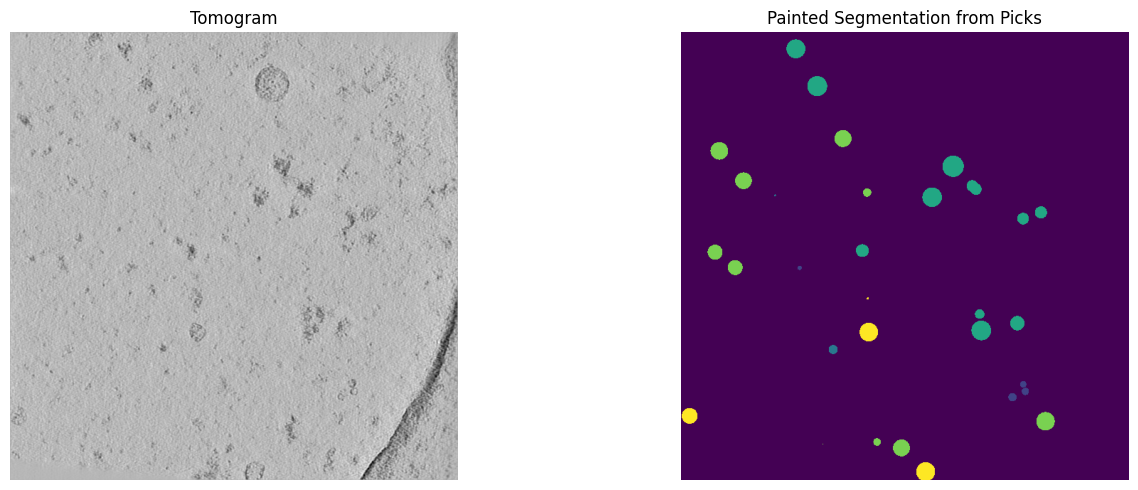

In [18]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(data_dicts[0]['image'][100],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Painted Segmentation from Picks')
plt.imshow(data_dicts[0]['label'][100], cmap='viridis')
plt.axis('off')

plt.tight_layout()
plt.show()

# Simulated data prep

In [19]:
simulated_data_path = '../../czii_downloaded_data/simulated_training_data/'

In [20]:
simulated_experiments_list = [f for f in os.listdir(simulated_data_path) if 'TS_' in f]
simulated_experiments_list

['TS_26',
 'TS_13',
 'TS_22',
 'TS_17',
 'TS_1',
 'TS_24',
 'TS_19',
 'TS_4',
 'TS_6',
 'TS_23',
 'TS_2',
 'TS_16',
 'TS_14',
 'TS_20',
 'TS_18',
 'TS_0',
 'TS_21',
 'TS_3',
 'TS_9',
 'TS_7',
 'TS_10',
 'TS_11',
 'TS_25',
 'TS_12',
 'TS_15',
 'TS_5',
 'TS_8']

In [21]:
particle_info = {
    "apo-ferritin": {"label": 1, "radius": 60},
    "beta-galactosidase": {"label": 2, "radius": 90},
    "ribosome": {"label": 3, "radius": 150},
    "thyroglobulin": {"label": 4, "radius": 130},
    "virus-like-particle": {"label": 5, "radius": 135}
}

In [22]:
def create_masks(image, locations_df):
    shape = image.shape
    volume = np.zeros(shape, dtype=np.uint8)

    for i in range(locations_df.shape[0]):
        center = (locations_df.loc[i, 'z'], locations_df.loc[i, 'y'], locations_df.loc[i, 'x'])
        radius = locations_df.loc[i, 'radius']
        intensity = locations_df.loc[i, 'label']

        z, y, x = np.ogrid[:shape[0], :shape[1], :shape[2]]
        
        mask = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2 <= radius**2

        volume[mask] = intensity

    return volume

In [23]:
particle_name_dict = {
    'ferritin':'apo-ferritin',
    'galacto':'beta-galactosidase',
    'ribosome':'ribosome',
    'thyro':'thyroglobulin',
    'vlp':'virus-like-particle'
}

In [24]:
def process_experiment(experiment):
    """Process a single experiment in parallel"""
    # Load tomogram data
    tomogram_path = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Tomograms/100/{experiment}.zarr'
    tomogram = zarr.open(tomogram_path, mode='r')[0].__array__()
    
    location_dfs_list = []
    annotations_base = f'{simulated_data_path}{experiment}/Reconstructions/VoxelSpacing10.000/Annotations/'
    
    # Process location files
    for location_folder in os.listdir(annotations_base):
        location_dir = os.path.join(annotations_base, location_folder)
        for location_file in os.listdir(location_dir):
            if 'orientedpoint.ndjson' not in location_file:
                continue
                
            # Determine particle type
            particle_type = None
            for key in particle_name_dict.keys():
                if key in location_file:
                    particle_type = particle_name_dict[key]
                    break
            if not particle_type:
                continue
                
            # Process NDJSON file
            label = particle_info[particle_type]['label']
            radius = particle_info[particle_type]['radius']
            file_path = os.path.join(location_dir, location_file)
            
            location_df = pd.read_json(file_path, lines=True)
            location_df['x'] = location_df['location'].map(lambda x: x['x'])
            location_df['y'] = location_df['location'].map(lambda x: x['y'])
            location_df['z'] = location_df['location'].map(lambda x: x['z'])
            location_df['label'] = label
            location_df['radius'] = radius / 10# * 0.5
            location_df['particle_type'] = particle_type
            
            location_dfs_list.append(location_df)
    
    # Create mask and return result
    if location_dfs_list:
        all_particle_locations_df = pd.concat(location_dfs_list, ignore_index=True)
        mask_image = create_masks(tomogram, all_particle_locations_df)
        all_particle_locations_df['experiment'] = experiment
        label_df = all_particle_locations_df[['experiment', 'particle_type', 'x', 'y', 'z', 'radius', 'label']]
        return {"tomo_type": 'Unknown', "image": tomogram, "label": mask_image, "label_df": label_df}
    return None

def append_simulation_data():
    global data_dicts
    max_workers = os.cpu_count() // 2  # Use half the available cores to prevent memory issues
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all experiments for processing
        futures = [executor.submit(process_experiment, exp) for exp in simulated_experiments_list]
        
        # Collect results as they complete
        for future in tqdm(concurrent.futures.as_completed(futures), 
                         total=len(simulated_experiments_list),
                         desc="Processing experiments"):
            result = future.result()
            if result:
                data_dicts.append(result)

In [25]:
append_simulation_data()

Processing experiments: 100%|█████████████████████████████████████| 27/27 [13:00<00:00, 28.89s/it]


In [26]:
len(data_dicts)

34

In [27]:
temp_image = data_dicts[-1]['image']
temp_image.shape

(200, 630, 630)

In [28]:
temp_label = data_dicts[-1]['label']
temp_label.shape

(200, 630, 630)

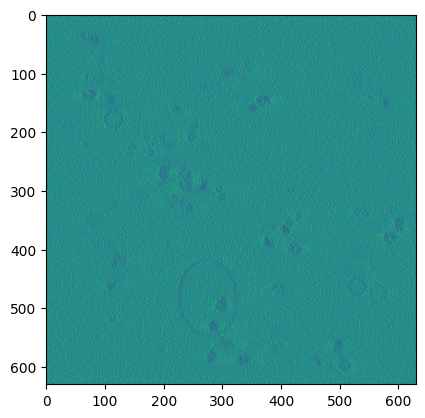

In [29]:
plt.imshow(temp_image[100])

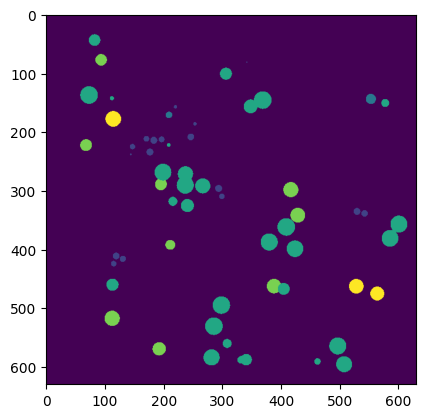

In [30]:
plt.imshow(temp_label[100])

In [31]:
data_dicts[-1]['label_df']

,experiment,particle_type,x,y,z,radius,label
0,TS_8,beta-galactosidase,494.768532,110.539669,159.719701,9.0,2
1,TS_8,beta-galactosidase,524.927406,124.729222,178.547967,9.0,2
2,TS_8,beta-galactosidase,521.786589,96.223810,163.683301,9.0,2
3,TS_8,beta-galactosidase,514.622803,137.626747,180.715754,9.0,2
4,TS_8,beta-galactosidase,531.309330,132.442002,143.342971,9.0,2
...,...,...,...,...,...,...,...
431,TS_8,virus-like-particle,515.893176,487.183684,68.281203,13.5,5
432,TS_8,virus-like-particle,527.831757,463.086076,105.259160,13.5,5
433,TS_8,virus-like-particle,563.562417,475.424917,106.449972,13.5,5
434,TS_8,virus-like-particle,108.649480,265.829585,45.990704,13.5,5


## 5. Prepare dataloaders

In [32]:
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss, FocalLoss, TverskyLoss
from monai.metrics import DiceMetric, ConfusionMatrixMetric

In [33]:
exp_names_list = []
for i in range(len(data_dicts)):
    exp_name = data_dicts[i]['label_df']['experiment'][0]
    exp_names_list.append(exp_name)
exp_names_sr = pd.Series(exp_names_list)
unique_exp_names = exp_names_sr.unique()
unique_exp_names

array(['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3',
       'TS_99_9', 'TS_1', 'TS_24', 'TS_4', 'TS_13', 'TS_17', 'TS_22',
       'TS_19', 'TS_26', 'TS_23', 'TS_6', 'TS_2', 'TS_16', 'TS_20',
       'TS_14', 'TS_18', 'TS_0', 'TS_3', 'TS_11', 'TS_7', 'TS_21',
       'TS_10', 'TS_12', 'TS_25', 'TS_9', 'TS_5', 'TS_15', 'TS_8'],
      dtype=object)

In [34]:
len(unique_exp_names)

34

In [35]:
random_exps = random.sample([i for i in range(len(unique_exp_names))], int(len(unique_exp_names)/5))
val_exps = unique_exp_names[random_exps]
val_exps

array(['TS_6_4', 'TS_11', 'TS_6', 'TS_7', 'TS_4', 'TS_5'], dtype=object)

In [36]:
train_files = []
val_files = []
for i in range(len(data_dicts)):
    exp_name = data_dicts[i]['label_df']['experiment'][0]
    if exp_name in val_exps:
        val_files.append(data_dicts[i])
    else:
        train_files.append(data_dicts[i])

In [37]:
print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")

Number of training samples: 28
Number of validation samples: 6


In [38]:
train_files_copy = copy.deepcopy(train_files)
val_files_copy = copy.deepcopy(val_files)

In [39]:
for i in range(len(train_files)):
    del train_files[i]['tomo_type'], train_files[i]['label_df']

for i in range(len(val_files)):
    del val_files[i]['tomo_type'], val_files[i]['label_df']

In [40]:
num_classes = 6 # 5 particles + 1 background
my_num_samples = 16
train_batch_size = 1
val_batch_size = 1

In [41]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,
        allow_missing_keys=True
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

# Create the cached dataset with non-random transforms
train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
train_ds = Dataset(data=train_ds, transform=random_transforms)

# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available()
)

# Validation transforms
val_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=num_classes,
        num_samples=my_num_samples,  # Use 1 to get a single, consistent crop per image
        allow_missing_keys=True
    ),
])

# Create validation dataset
val_ds = CacheDataset(data=val_files, transform=non_random_transforms, cache_rate=1.0)

# Wrap the cached dataset to apply random transforms during iteration
val_ds = Dataset(data=val_ds, transform=random_transforms)

# Create validation DataLoader
val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    shuffle=False,  # Ensure the data order remains consistent
)

Loading dataset: 100%|██████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s]


## Model setup

In [42]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
class FBetaLoss(nn.Module):
    def __init__(self, beta=4, eps=1e-6, class_weights=None, enzyme_classes=5):
        super().__init__()
        self.beta = beta
        self.eps = eps
        self.enzyme_classes = enzyme_classes
        
        self.class_weights = class_weights or {
            'apo-ferritin': 1,
            'beta-galactosidase': 2,
            'ribosome': 1,
            'thyroglobulin': 2,
            'virus-like-particle': 1,
        }
        self.weight_tensor = torch.tensor(
            [self.class_weights[k] for k in self.class_weights.keys()],
            dtype=torch.float32
        )

    def forward(self, y_pred, y_true):
        # Convert y_true to proper format
        y_true = y_true.squeeze(1).long()  # Remove channel dim & ensure integer type
        
        y_pred_probs = F.softmax(y_pred, dim=1)
        y_pred_enzymes = y_pred_probs[:, 1:self.enzyme_classes+1, ...]
        
        # One-hot encoding with proper type handling
        y_true_onehot = F.one_hot(y_true, num_classes=6).permute(0, 4, 1, 2, 3).float()
        y_true_enzymes = y_true_onehot[:, 1:self.enzyme_classes+1, ...]

        tp = (y_pred_enzymes * y_true_enzymes).sum(dim=(2, 3, 4))
        fp = (y_pred_enzymes * (1 - y_true_enzymes)).sum(dim=(2, 3, 4))
        fn = ((1 - y_pred_enzymes) * y_true_enzymes).sum(dim=(2, 3, 4))

        precision = tp / (tp + fp + self.eps)
        recall = tp / (tp + fn + self.eps)
        beta2 = self.beta ** 2
        f_beta = (1 + beta2) * (precision * recall) / (beta2 * precision + recall + self.eps)

        weight_tensor = self.weight_tensor.to(y_pred.device)
        weighted_f_beta = f_beta * weight_tensor
        aggregate_f_beta = weighted_f_beta.sum(dim=1) / weight_tensor.sum()
        
        return 1 - aggregate_f_beta.mean()

In [45]:
fbeta_loss_function = FBetaLoss()

In [46]:
class ParticleTverskyCrossEntropyLoss(nn.Module):
    def __init__(self, particle_weights, alpha=16/17, beta=1/17, ce_weight=1.0, tversky_weight=1.0, smooth=1e-6):
        """
        Args:
            particle_weights (torch.Tensor): Weights for 5 particles + background [0.0, 1.0, 2.0, 1.0, 2.0, 1.0]
            alpha: Tversky FP weight (prioritizes recall for beta=4)
            beta: Tversky FN weight
        """
        super().__init__()
        self.ce_weight = ce_weight
        self.tversky_weight = tversky_weight
        self.smooth = smooth
        self.alpha = alpha
        self.beta = beta
        
        # Cross-Entropy with particle weights (background weight=0)
        self.ce = nn.CrossEntropyLoss(weight=particle_weights)
        self.register_buffer('class_weights', particle_weights)  # [6] tensor

    def forward(self, inputs, targets):
        # Ensure targets have the correct shape and dtype
        ce_loss = self.ce(inputs, targets.squeeze(1).long())
    
        # Tversky Loss (3D-compatible)
        num_classes = inputs.shape[1]
        probs = F.softmax(inputs, dim=1)
        targets_onehot = F.one_hot(targets.squeeze(1).long(), num_classes).permute(0, 4, 1, 2, 3).float()  # BCDHW
    
        # Flatten spatial dimensions (3D)
        probs_flat = probs.view(probs.size(0), num_classes, -1)  # [B,6,D*H*W]
        targets_flat = targets_onehot.view(targets_onehot.size(0), num_classes, -1)
    
        # Calculate TP/FP/FN (broadcasted across classes)
        tp = (probs_flat * targets_flat).sum(dim=2)  # [B,6]
        fp = (probs_flat * (1 - targets_flat)).sum(dim=2)
        fn = ((1 - probs_flat) * targets_flat).sum(dim=2)
    
        # Tversky index per class
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)  # [B,6]
        tversky_loss = 1 - tversky
    
        # Apply class weights
        weighted_tversky = tversky_loss * self.class_weights  # [B,6]
        tversky_loss = weighted_tversky.mean()
    
        # Combined loss
        return self.ce_weight * ce_loss + self.tversky_weight * tversky_loss

In [47]:
# Class order: [background, apo-ferritin, beta-galactosidase, ribosome, thyroglobulin, virus-like-particle]
particle_weights = torch.tensor([
    0.0,  # Background (weight=0)
    1.0,  # apo-ferritin
    2.0,  # beta-galactosidase (higher weight)
    1.0,  # ribosome
    2.0,  # thyroglobulin (higher weight)
    1.0   # virus-like-particle
], device='cuda')

wtversky_ce_loss_function = ParticleTverskyCrossEntropyLoss(
    particle_weights=particle_weights,
    ce_weight=1.0,  # Balance with Tversky
    tversky_weight=1.0  # Emphasize recall
)

In [48]:
#loss_function = DiceLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
tversky_loss_function = TverskyLoss(include_background=False, to_onehot_y=True, softmax=True, alpha=16/17, beta=1/17)  # softmax=True for multiclass
dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)  # must use onehot for multiclass
recall_metric = ConfusionMatrixMetric(include_background=False, metric_name="recall", reduction="None")

In [49]:
post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
post_label = AsDiscrete(to_onehot=num_classes)

In [50]:
from typing import List, Tuple, Union
import cc3d


def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

    
def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed

    
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions
    

def dict_to_df(coord_dict, experiment_name):
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    return df

In [51]:
id_to_name = {1: "apo-ferritin", 
              #2: "beta-amylase",
              2: "beta-galactosidase", 
              3: "ribosome", 
              4: "thyroglobulin", 
              5: "virus-like-particle"}

In [52]:
classes = [1, 2, 3, 4, 5]

In [53]:
def ensemble_prediction_tta(model, input_tensor, threshold=0.05):
    probs_list = []
    
    data_copy0 = input_tensor.clone()
    data_copy0 = torch.flip(data_copy0, dims=[2])
    data_copy1 = input_tensor.clone()
    data_copy1 = torch.flip(data_copy1, dims=[3])
    data_copy2 = input_tensor.clone()
    data_copy2 = torch.flip(data_copy2, dims=[4])
    data_copy3 = input_tensor.clone()
    data_copy3 = data_copy3.rot90(1, dims=[3, 4])
    
    model_output0 = model(input_tensor)
    model_output1 = model(data_copy0)
    model_output1 = torch.flip(model_output1, dims=[2])
    model_output2 = model(data_copy1)
    model_output2 = torch.flip(model_output2, dims=[3])
    model_output3 = model(data_copy2)
    model_output3 = torch.flip(model_output3, dims=[4])
    
    probs0 = torch.softmax(model_output0[0], dim=0)
    probs1 = torch.softmax(model_output1[0], dim=0)
    probs2 = torch.softmax(model_output2[0], dim=0)
    probs3 = torch.softmax(model_output3[0], dim=0)
    
    probs_list.append(probs0)
    probs_list.append(probs1)
    probs_list.append(probs2)
    probs_list.append(probs3)
    
    avg_probs = torch.mean(torch.stack(probs_list), dim=0)
    thresh_probs = avg_probs > threshold
    _, max_classes = thresh_probs.max(dim=0)
    
    return max_classes

In [54]:
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [55]:
loss_function_dict = {
    'fbeta': fbeta_loss_function,
    'wtversky_ce': wtversky_ce_loss_function,
    'tversky': tversky_loss_function
}

In [56]:
def objective(trial: optuna.Trial) -> float:
    learning_rate = trial.suggest_float('learning_rate', 3e-4, 3e-3)
    third_channel = trial.suggest_int('third_channel', 80, 128)
    fourth_channel = trial.suggest_int('fourth_channel', 80, 128)
    last_stride = trial.suggest_int('last_stride', 1, 2)
    num_res_units = trial.suggest_int('num_res_units', 1, 4)
    loss_function_name = trial.suggest_categorical('loss_function', ['fbeta', 'wtversky_ce', 'tversky'])
    loss_function = loss_function_dict[loss_function_name]
    prediction_threshold = trial.suggest_float('prediction_threshold', 0.01, 0.2)

    # Create UNet, DiceLoss and Adam optimizer
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=num_classes,
        channels=(48, 64, third_channel, fourth_channel),
        strides=(2, 2, last_stride),
        num_res_units=num_res_units,
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    model.to('cuda')
    model = torch.compile(model, mode="max-autotune")

    torch.set_float32_matmul_precision('high')
    
    #scaler = torch.amp.GradScaler('cuda')
    autocast_dtype = torch.bfloat16

    best_val_score = 0

    max_epochs = 15
    
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs = batch_data["image"].to(device, non_blocking=True)
            labels = batch_data["label"].to(device, non_blocking=True)
    
            optimizer.zero_grad()

            with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        epoch_loss /= step
        #epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        #mlflow.log_metric("train_loss", epoch_loss, step=epoch+1)
        
        model.eval()
        with torch.no_grad():
            with torch.amp.autocast(device_type='cuda', dtype=autocast_dtype):
                
                solution_dfs_list = []
                submission_dfs_list = []
                exp_names_list = []
    
                for i in range(len(val_files_copy)):
                    val_data = val_files_copy[i]
    
                    exp_name = val_data['label_df']['experiment'][0]
                    if exp_name in exp_names_list:
                        continue
                    else:
                        exp_names_list.append(exp_name)
        
                    tomo = val_data['image']
                    tomo_patches, coordinates = extract_3d_patches_minimal_overlap([tomo], 96)
                    tomo_patched_data = [{"image": img} for img in tomo_patches]
                    tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0, progress=False, num_workers=8)
                    pred_masks = []
                    for i in range(len(tomo_ds)):
                        input_tensor = tomo_ds[i]['image'].unsqueeze(0).to("cuda", non_blocking=True)
                        max_classes = ensemble_prediction_tta(model, input_tensor, threshold=prediction_threshold)
                        pred_masks.append(max_classes.cpu().numpy())
        
                    reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)
                    location = {}
                    for c in classes:
                        cc = cc3d.connected_components(reconstructed_mask == c)
                        stats = cc3d.statistics(cc)
                        zyx = stats['centroids'][1:]
                        zyx_large = zyx[stats['voxel_counts'][1:] > 255]
                        xyz = np.ascontiguousarray(zyx_large[:, ::-1])
                        location[id_to_name[c]] = xyz
                    df = dict_to_df(location, val_data['label_df']['experiment'][0])
        
                    solution_df = val_data['label_df']
    
                    solution_dfs_list.append(solution_df)
                    submission_dfs_list.append(df)
    
                solution_concat_df = pd.concat(solution_dfs_list, ignore_index=True).reset_index(drop=True).reset_index().rename(columns={'index':'id'})[['id', 'experiment', 'particle_type', 'x', 'y', 'z']]
                submission_concat_df = pd.concat(submission_dfs_list, ignore_index=True).reset_index(drop=True).reset_index().rename(columns={'index':'id'})
        
                val_fbeta_score = score(solution_concat_df, submission_concat_df, 'id', 0.1*0.5, 4)
    
                print(f'Epoch {epoch+1} validation F beta score: ', val_fbeta_score)
    
                if val_fbeta_score > best_val_score:
                    best_val_score = val_fbeta_score

    return best_val_score

In [57]:
notebook_number = '20250131_01'
optuna_n_trials = 100

with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
    
    # Define a callback function to update the progress bar
    def progress_bar_callback(study, trial):
        pbar.update(1)

    study = optuna.create_study(
        direction="maximize",
        sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler(),
        storage="sqlite:////home/max1024/Python Notebooks/czii/optuna_study/db.sqlite3",
        study_name=f"czii_3D_UNet_param_tune_{notebook_number}"
    )
    study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

[I 2025-01-31 02:01:25,659] A new study created in RDB with name: czii_3D_UNet_param_tune_20250131_01


----------
epoch 1/15
epoch 1 average loss: 0.9552
Epoch 1 validation F beta score:  0.05249296551867676
----------
epoch 2/15
epoch 2 average loss: 0.9098
Epoch 2 validation F beta score:  0.089056058325607
----------
epoch 3/15
epoch 3 average loss: 0.8877
Epoch 3 validation F beta score:  0.15124287046813226
----------
epoch 4/15
epoch 4 average loss: 0.8864
Epoch 4 validation F beta score:  0.16914941417057935
----------
epoch 5/15
epoch 5 average loss: 0.8774
Epoch 5 validation F beta score:  0.15479035234712632
----------
epoch 6/15
epoch 6 average loss: 0.8619
Epoch 6 validation F beta score:  0.16072773511012559
----------
epoch 7/15
epoch 7 average loss: 0.8483
Epoch 7 validation F beta score:  0.09801622571459313
----------
epoch 8/15
epoch 8 average loss: 0.8363
Epoch 8 validation F beta score:  0.18483821967601524
----------
epoch 9/15
epoch 9 average loss: 0.8129
Epoch 9 validation F beta score:  0.17696544340621131
----------
epoch 10/15
epoch 10 average loss: 0.7961
Epoc

[I 2025-01-31 02:20:09,558] Trial 0 finished with value: 0.38955158798958783 and parameters: {'learning_rate': 0.0011073067432169096, 'third_channel': 97, 'fourth_channel': 115, 'last_stride': 2, 'num_res_units': 4, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.018115853443138204}. Best is trial 0 with value: 0.38955158798958783.
Optimizing:   1%|▍                                        | 1/100 [18:44<30:55:12, 1124.37s/trial]

Epoch 15 validation F beta score:  0.34791745666440826
----------
epoch 1/15


/home/max1024/venvs/ml/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/max1024/venvs/ml/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(


epoch 1 average loss: 0.9593
Epoch 1 validation F beta score:  0.07673690250529171
----------
epoch 2/15
epoch 2 average loss: 0.9177
Epoch 2 validation F beta score:  0.14047877996681465
----------
epoch 3/15
epoch 3 average loss: 0.9005
Epoch 3 validation F beta score:  0.23005393659653683
----------
epoch 4/15
epoch 4 average loss: 0.8872
Epoch 4 validation F beta score:  0.2714225554274164
----------
epoch 5/15
epoch 5 average loss: 0.8822
Epoch 5 validation F beta score:  0.22988607441211945
----------
epoch 6/15
epoch 6 average loss: 0.8799
Epoch 6 validation F beta score:  0.291751742686568
----------
epoch 7/15
epoch 7 average loss: 0.8728
Epoch 7 validation F beta score:  0.23896970385057167
----------
epoch 8/15
epoch 8 average loss: 0.8712
Epoch 8 validation F beta score:  0.3407574478960916
----------
epoch 9/15
epoch 9 average loss: 0.8583
Epoch 9 validation F beta score:  0.3093472413956791
----------
epoch 10/15
epoch 10 average loss: 0.8448
Epoch 10 validation F beta sc

[I 2025-01-31 02:36:48,123] Trial 1 finished with value: 0.347926355753304 and parameters: {'learning_rate': 0.0008288295214619889, 'third_channel': 119, 'fourth_channel': 123, 'last_stride': 2, 'num_res_units': 2, 'loss_function': 'tversky', 'prediction_threshold': 0.0870281095383639}. Best is trial 0 with value: 0.38955158798958783.
Optimizing:   2%|▊                                        | 2/100 [35:22<28:35:35, 1050.37s/trial]

Epoch 15 validation F beta score:  0.25145461787952544
----------
epoch 1/15
epoch 1 average loss: 0.9538
Epoch 1 validation F beta score:  0.05599897706740325
----------
epoch 2/15
epoch 2 average loss: 0.9102
Epoch 2 validation F beta score:  0.09012373665656477
----------
epoch 3/15
epoch 3 average loss: 0.8902
Epoch 3 validation F beta score:  0.08769015576936458
----------
epoch 4/15
epoch 4 average loss: 0.8659
Epoch 4 validation F beta score:  0.11970952204727996
----------
epoch 5/15
epoch 5 average loss: 0.8408
Epoch 5 validation F beta score:  0.1435347863797436
----------
epoch 6/15
epoch 6 average loss: 0.8397
Epoch 6 validation F beta score:  0.18809256931897886
----------
epoch 7/15
epoch 7 average loss: 0.8158
Epoch 7 validation F beta score:  0.20657553071851628
----------
epoch 8/15
epoch 8 average loss: 0.7913
Epoch 8 validation F beta score:  0.27314749806775035
----------
epoch 9/15
epoch 9 average loss: 0.7844
Epoch 9 validation F beta score:  0.3299159815930122
--

[I 2025-01-31 02:52:47,683] Trial 2 finished with value: 0.4176475048393451 and parameters: {'learning_rate': 0.0014660921472540798, 'third_channel': 86, 'fourth_channel': 89, 'last_stride': 1, 'num_res_units': 2, 'loss_function': 'fbeta', 'prediction_threshold': 0.06240428991585888}. Best is trial 2 with value: 0.4176475048393451.
Optimizing:   3%|█▏                                       | 3/100 [51:22<27:11:03, 1008.90s/trial]

Epoch 15 validation F beta score:  0.4176475048393451
----------
epoch 1/15
epoch 1 average loss: 0.9625
Epoch 1 validation F beta score:  0.03496768925568756
----------
epoch 2/15
epoch 2 average loss: 0.9175
Epoch 2 validation F beta score:  0.13548670490800738
----------
epoch 3/15
epoch 3 average loss: 0.8985
Epoch 3 validation F beta score:  0.1544740541668415
----------
epoch 4/15
epoch 4 average loss: 0.8875
Epoch 4 validation F beta score:  0.10732199414289316
----------
epoch 5/15
epoch 5 average loss: 0.8601
Epoch 5 validation F beta score:  0.17908517779837776
----------
epoch 6/15
epoch 6 average loss: 0.8327
Epoch 6 validation F beta score:  0.2064851528977976
----------
epoch 7/15
epoch 7 average loss: 0.8204
Epoch 7 validation F beta score:  0.23926525005365443
----------
epoch 8/15
epoch 8 average loss: 0.8156
Epoch 8 validation F beta score:  0.2610537030599818
----------
epoch 9/15
epoch 9 average loss: 0.7966
Epoch 9 validation F beta score:  0.2841532373999844
-----

[I 2025-01-31 03:12:41,283] Trial 3 finished with value: 0.45861766785570535 and parameters: {'learning_rate': 0.0010684818398279115, 'third_channel': 110, 'fourth_channel': 100, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.061485408680355326}. Best is trial 3 with value: 0.45861766785570535.
Optimizing:   4%|█▌                                     | 4/100 [1:11:16<28:50:54, 1081.82s/trial]

Epoch 15 validation F beta score:  0.45861766785570535
----------
epoch 1/15
epoch 1 average loss: 0.9501
Epoch 1 validation F beta score:  0.11439039132878717
----------
epoch 2/15
epoch 2 average loss: 0.9052
Epoch 2 validation F beta score:  0.1824694793518323
----------
epoch 3/15
epoch 3 average loss: 0.8883
Epoch 3 validation F beta score:  0.2699077201425818
----------
epoch 4/15
epoch 4 average loss: 0.8830
Epoch 4 validation F beta score:  0.12617034925459242
----------
epoch 5/15
epoch 5 average loss: 0.8862
Epoch 5 validation F beta score:  0.10111411431924622
----------
epoch 6/15
epoch 6 average loss: 0.8624
Epoch 6 validation F beta score:  0.1070160993465643
----------
epoch 7/15
epoch 7 average loss: 0.8536
Epoch 7 validation F beta score:  0.10945969302811916
----------
epoch 8/15
epoch 8 average loss: 0.8614
Epoch 8 validation F beta score:  0.15165106462685163
----------
epoch 9/15
epoch 9 average loss: 0.8565
Epoch 9 validation F beta score:  0.1518065419733787
----

[I 2025-01-31 03:32:19,787] Trial 4 finished with value: 0.3142082839099437 and parameters: {'learning_rate': 0.002628134689942248, 'third_channel': 126, 'fourth_channel': 81, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.013047338801929915}. Best is trial 3 with value: 0.45861766785570535.
Optimizing:   5%|█▉                                     | 5/100 [1:30:54<29:28:04, 1116.68s/trial]

Epoch 15 validation F beta score:  0.3142082839099437
----------
epoch 1/15
epoch 1 average loss: 0.9516
Epoch 1 validation F beta score:  0.04667640162889227
----------
epoch 2/15
epoch 2 average loss: 0.9093
Epoch 2 validation F beta score:  0.12213256742768104
----------
epoch 3/15
epoch 3 average loss: 0.8969
Epoch 3 validation F beta score:  0.14725825409646304
----------
epoch 4/15
epoch 4 average loss: 0.8871
Epoch 4 validation F beta score:  0.10093987144345244
----------
epoch 5/15
epoch 5 average loss: 0.8693
Epoch 5 validation F beta score:  0.11133921193618275
----------
epoch 6/15
epoch 6 average loss: 0.8566
Epoch 6 validation F beta score:  0.15297306657249954
----------
epoch 7/15
epoch 7 average loss: 0.8654
Epoch 7 validation F beta score:  0.11806892657801052
----------
epoch 8/15
epoch 8 average loss: 0.8449
Epoch 8 validation F beta score:  0.16512203085046906
----------
epoch 9/15
epoch 9 average loss: 0.8374
Epoch 9 validation F beta score:  0.2054617869209579
--

[I 2025-01-31 03:51:49,600] Trial 5 finished with value: 0.3599233603621655 and parameters: {'learning_rate': 0.0021971020979449094, 'third_channel': 93, 'fourth_channel': 81, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'tversky', 'prediction_threshold': 0.15723897543209245}. Best is trial 3 with value: 0.45861766785570535.
Optimizing:   6%|██▎                                    | 6/100 [1:50:24<29:37:46, 1134.75s/trial]

Epoch 15 validation F beta score:  0.3599233603621655
----------
epoch 1/15
epoch 1 average loss: 0.9635
Epoch 1 validation F beta score:  0.022338150605225728
----------
epoch 2/15
epoch 2 average loss: 0.9378
Epoch 2 validation F beta score:  0.07928113270438489
----------
epoch 3/15
epoch 3 average loss: 0.9158
Epoch 3 validation F beta score:  0.06316783877401069
----------
epoch 4/15
epoch 4 average loss: 0.9011
Epoch 4 validation F beta score:  0.1508287142813829
----------
epoch 5/15
epoch 5 average loss: 0.8941
Epoch 5 validation F beta score:  0.177088178859602
----------
epoch 6/15
epoch 6 average loss: 0.8840
Epoch 6 validation F beta score:  0.20414570605880705
----------
epoch 7/15
epoch 7 average loss: 0.8752
Epoch 7 validation F beta score:  0.19376487940101791
----------
epoch 8/15
epoch 8 average loss: 0.8771
Epoch 8 validation F beta score:  0.17223029390703853
----------
epoch 9/15
epoch 9 average loss: 0.8731
Epoch 9 validation F beta score:  0.2090461724592391
----

[I 2025-01-31 04:14:04,679] Trial 6 finished with value: 0.38838461573651706 and parameters: {'learning_rate': 0.0006101335746740898, 'third_channel': 103, 'fourth_channel': 99, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'fbeta', 'prediction_threshold': 0.13298756990220362}. Best is trial 3 with value: 0.45861766785570535.
Optimizing:   7%|██▋                                    | 7/100 [2:12:39<31:00:22, 1200.24s/trial]

Epoch 15 validation F beta score:  0.38838461573651706
----------
epoch 1/15
epoch 1 average loss: 0.9451
Epoch 1 validation F beta score:  0.11293241651153874
----------
epoch 2/15
epoch 2 average loss: 0.8958
Epoch 2 validation F beta score:  0.18444494488002425
----------
epoch 3/15
epoch 3 average loss: 0.8888
Epoch 3 validation F beta score:  0.15751505784807043
----------
epoch 4/15
epoch 4 average loss: 0.8774
Epoch 4 validation F beta score:  0.1133960907181577
----------
epoch 5/15
epoch 5 average loss: 0.8702
Epoch 5 validation F beta score:  0.14063885617601243
----------
epoch 6/15
epoch 6 average loss: 0.8656
Epoch 6 validation F beta score:  0.1545896539953066
----------
epoch 7/15
epoch 7 average loss: 0.8449
Epoch 7 validation F beta score:  0.1533020018597652
----------
epoch 8/15
epoch 8 average loss: 0.8373
Epoch 8 validation F beta score:  0.1487576188406641
----------
epoch 9/15
epoch 9 average loss: 0.8295
Epoch 9 validation F beta score:  0.12359201526054632
----

[I 2025-01-31 04:32:54,275] Trial 7 finished with value: 0.5020150558365648 and parameters: {'learning_rate': 0.0027914854209138695, 'third_channel': 85, 'fourth_channel': 118, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'fbeta', 'prediction_threshold': 0.15850596661936267}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:   8%|███                                    | 8/100 [2:31:29<30:05:53, 1177.75s/trial]

Epoch 15 validation F beta score:  0.47246050770404185
----------
epoch 1/15
epoch 1 average loss: 0.9479
Epoch 1 validation F beta score:  0.21972346183712133
----------
epoch 2/15
epoch 2 average loss: 0.9017
Epoch 2 validation F beta score:  0.2636793370939286
----------
epoch 3/15
epoch 3 average loss: 0.8829
Epoch 3 validation F beta score:  0.1502247604139518
----------
epoch 4/15
epoch 4 average loss: 0.8702
Epoch 4 validation F beta score:  0.19423685787035042
----------
epoch 5/15
epoch 5 average loss: 0.8639
Epoch 5 validation F beta score:  0.19196824146192898
----------
epoch 6/15
epoch 6 average loss: 0.8484
Epoch 6 validation F beta score:  0.2356619922385891
----------
epoch 7/15
epoch 7 average loss: 0.8455
Epoch 7 validation F beta score:  0.18197586167171428
----------
epoch 8/15
epoch 8 average loss: 0.8361
Epoch 8 validation F beta score:  0.2603527273188698
----------
epoch 9/15
epoch 9 average loss: 0.8291
Epoch 9 validation F beta score:  0.1750559471313335
-----

[I 2025-01-31 04:53:09,806] Trial 8 finished with value: 0.33985823298626305 and parameters: {'learning_rate': 0.0015976937139187246, 'third_channel': 107, 'fourth_channel': 122, 'last_stride': 2, 'num_res_units': 4, 'loss_function': 'fbeta', 'prediction_threshold': 0.1868815812655404}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:   9%|███▌                                   | 9/100 [2:51:44<30:04:10, 1189.56s/trial]

Epoch 15 validation F beta score:  0.328394302544941
----------
epoch 1/15
epoch 1 average loss: 0.9492
Epoch 1 validation F beta score:  0.07633713399777846
----------
epoch 2/15
epoch 2 average loss: 0.9006
Epoch 2 validation F beta score:  0.08012903175506458
----------
epoch 3/15
epoch 3 average loss: 0.8954
Epoch 3 validation F beta score:  0.08788968284950827
----------
epoch 4/15
epoch 4 average loss: 0.8883
Epoch 4 validation F beta score:  0.08322143798090341
----------
epoch 5/15
epoch 5 average loss: 0.8892
Epoch 5 validation F beta score:  0.10030110609668384
----------
epoch 6/15
epoch 6 average loss: 0.8863
Epoch 6 validation F beta score:  0.09584457411668006
----------
epoch 7/15
epoch 7 average loss: 0.8677
Epoch 7 validation F beta score:  0.0973791645770912
----------
epoch 8/15
epoch 8 average loss: 0.8611
Epoch 8 validation F beta score:  0.13965949858941037
----------
epoch 9/15
epoch 9 average loss: 0.8544
Epoch 9 validation F beta score:  0.12881340353984735
---

[I 2025-01-31 05:09:31,786] Trial 9 finished with value: 0.1609340125551308 and parameters: {'learning_rate': 0.0017377652825929554, 'third_channel': 100, 'fourth_channel': 114, 'last_stride': 1, 'num_res_units': 2, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.06855033643961239}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  10%|███▊                                  | 10/100 [3:08:06<28:08:12, 1125.48s/trial]

Epoch 15 validation F beta score:  0.14955432206664962
----------
epoch 1/15
epoch 1 average loss: 0.9330
Epoch 1 validation F beta score:  0.09024912852985385
----------
epoch 2/15
epoch 2 average loss: 0.9164
Epoch 2 validation F beta score:  0.10100064278417258
----------
epoch 3/15
epoch 3 average loss: 0.8948
Epoch 3 validation F beta score:  0.17472254379429483
----------
epoch 4/15
epoch 4 average loss: 0.8768
Epoch 4 validation F beta score:  0.13622685764139905
----------
epoch 5/15
epoch 5 average loss: 0.8776
Epoch 5 validation F beta score:  0.10170614406751413
----------
epoch 6/15
epoch 6 average loss: 0.8688
Epoch 6 validation F beta score:  0.1542009169530685
----------
epoch 7/15
epoch 7 average loss: 0.8588
Epoch 7 validation F beta score:  0.11560123229979555
----------
epoch 8/15
epoch 8 average loss: 0.8487
Epoch 8 validation F beta score:  0.10748488409643746
----------
epoch 9/15
epoch 9 average loss: 0.8383
Epoch 9 validation F beta score:  0.10050001104266937
-

[I 2025-01-31 05:34:34,011] Trial 10 finished with value: 0.28033915197260223 and parameters: {'learning_rate': 0.0028970408985236696, 'third_channel': 87, 'fourth_channel': 120, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'fbeta', 'prediction_threshold': 0.1337721384014146}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  11%|████▏                                 | 11/100 [3:33:08<30:40:29, 1240.78s/trial]

Epoch 15 validation F beta score:  0.27632642053746426
----------
epoch 1/15
epoch 1 average loss: 0.9469
Epoch 1 validation F beta score:  0.0776718810921249
----------
epoch 2/15
epoch 2 average loss: 0.9092
Epoch 2 validation F beta score:  0.08626579482290826
----------
epoch 3/15
epoch 3 average loss: 0.9002
Epoch 3 validation F beta score:  0.09498531446320733
----------
epoch 4/15
epoch 4 average loss: 0.8889
Epoch 4 validation F beta score:  0.11132032010662997
----------
epoch 5/15
epoch 5 average loss: 0.8637
Epoch 5 validation F beta score:  0.09088452582084627
----------
epoch 6/15
epoch 6 average loss: 0.8590
Epoch 6 validation F beta score:  0.08580796712911003
----------
epoch 7/15
epoch 7 average loss: 0.8493
Epoch 7 validation F beta score:  0.08838431079553365
----------
epoch 8/15
epoch 8 average loss: 0.8432
Epoch 8 validation F beta score:  0.12392979728168872
----------
epoch 9/15
epoch 9 average loss: 0.8422
Epoch 9 validation F beta score:  0.11763185794277442
-

[I 2025-01-31 05:56:45,576] Trial 11 finished with value: 0.3564228898643516 and parameters: {'learning_rate': 0.0016755944544312464, 'third_channel': 100, 'fourth_channel': 99, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.09137059730286437}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  12%|████▌                                 | 12/100 [3:55:20<31:00:19, 1268.40s/trial]

Epoch 15 validation F beta score:  0.2648863217097505
----------
epoch 1/15
epoch 1 average loss: 0.9656
Epoch 1 validation F beta score:  0.05278271819496993
----------
epoch 2/15
epoch 2 average loss: 0.9402
Epoch 2 validation F beta score:  0.14055738624797334
----------
epoch 3/15
epoch 3 average loss: 0.9112
Epoch 3 validation F beta score:  0.1502547262279212
----------
epoch 4/15
epoch 4 average loss: 0.8975
Epoch 4 validation F beta score:  0.1667028653297759
----------
epoch 5/15
epoch 5 average loss: 0.8828
Epoch 5 validation F beta score:  0.20575581933076265
----------
epoch 6/15
epoch 6 average loss: 0.8633
Epoch 6 validation F beta score:  0.2150744477200046
----------
epoch 7/15
epoch 7 average loss: 0.8569
Epoch 7 validation F beta score:  0.22665390801273855
----------
epoch 8/15
epoch 8 average loss: 0.8556
Epoch 8 validation F beta score:  0.18193372769837485
----------
epoch 9/15
epoch 9 average loss: 0.8463
Epoch 9 validation F beta score:  0.2545687323821739
-----

[I 2025-01-31 06:16:27,719] Trial 12 finished with value: 0.33956309256563155 and parameters: {'learning_rate': 0.0004263169150972824, 'third_channel': 96, 'fourth_channel': 87, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.023163849085766575}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  13%|████▉                                 | 13/100 [4:15:02<30:01:17, 1242.27s/trial]

Epoch 15 validation F beta score:  0.2998952143144101
----------
epoch 1/15
epoch 1 average loss: 0.9528
Epoch 1 validation F beta score:  0.09360541596292297
----------
epoch 2/15
epoch 2 average loss: 0.9035
Epoch 2 validation F beta score:  0.12408588917327498
----------
epoch 3/15
epoch 3 average loss: 0.8789
Epoch 3 validation F beta score:  0.15559327047917185
----------
epoch 4/15
epoch 4 average loss: 0.8585
Epoch 4 validation F beta score:  0.19516332656290786
----------
epoch 5/15
epoch 5 average loss: 0.8652
Epoch 5 validation F beta score:  0.20088981432973366
----------
epoch 6/15
epoch 6 average loss: 0.8568
Epoch 6 validation F beta score:  0.1971192063341327
----------
epoch 7/15
epoch 7 average loss: 0.8519
Epoch 7 validation F beta score:  0.24098800112898475
----------
epoch 8/15
epoch 8 average loss: 0.8413
Epoch 8 validation F beta score:  0.24091544328374795
----------
epoch 9/15
epoch 9 average loss: 0.8256
Epoch 9 validation F beta score:  0.2500564999454104
---

[I 2025-01-31 06:37:52,990] Trial 13 finished with value: 0.39363200441013024 and parameters: {'learning_rate': 0.001241476400744765, 'third_channel': 111, 'fourth_channel': 81, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.11515359222475698}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  14%|█████▎                                | 14/100 [4:36:27<29:59:12, 1255.26s/trial]

Epoch 15 validation F beta score:  0.38639814662926575
----------
epoch 1/15
epoch 1 average loss: 0.9650
Epoch 1 validation F beta score:  0.06122673623892757
----------
epoch 2/15
epoch 2 average loss: 0.9312
Epoch 2 validation F beta score:  0.09572694637577199
----------
epoch 3/15
epoch 3 average loss: 0.9074
Epoch 3 validation F beta score:  0.11904155308776057
----------
epoch 4/15
epoch 4 average loss: 0.8942
Epoch 4 validation F beta score:  0.20459917348696202
----------
epoch 5/15
epoch 5 average loss: 0.8893
Epoch 5 validation F beta score:  0.11519152897650324
----------
epoch 6/15
epoch 6 average loss: 0.8710
Epoch 6 validation F beta score:  0.16167980370522114
----------
epoch 7/15
epoch 7 average loss: 0.8655
Epoch 7 validation F beta score:  0.1945449657459027
----------
epoch 8/15
epoch 8 average loss: 0.8578
Epoch 8 validation F beta score:  0.2538961090489068
----------
epoch 9/15
epoch 9 average loss: 0.8356
Epoch 9 validation F beta score:  0.23878565211272682
--

[I 2025-01-31 06:57:43,785] Trial 14 finished with value: 0.29583977259449895 and parameters: {'learning_rate': 0.0006851460825352756, 'third_channel': 127, 'fourth_channel': 97, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.01062311903424027}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  15%|█████▋                                | 15/100 [4:56:18<29:10:45, 1235.83s/trial]

Epoch 15 validation F beta score:  0.29583977259449895
----------
epoch 1/15
epoch 1 average loss: 0.9427
Epoch 1 validation F beta score:  0.1887962978245091
----------
epoch 2/15
epoch 2 average loss: 0.9065
Epoch 2 validation F beta score:  0.14137436701417294
----------
epoch 3/15
epoch 3 average loss: 0.9003
Epoch 3 validation F beta score:  0.11746255457088964
----------
epoch 4/15
epoch 4 average loss: 0.8931
Epoch 4 validation F beta score:  0.2031159943059155
----------
epoch 5/15
epoch 5 average loss: 0.8846
Epoch 5 validation F beta score:  0.1151853167529271
----------
epoch 6/15
epoch 6 average loss: 0.8660
Epoch 6 validation F beta score:  0.21299436091497156
----------
epoch 7/15
epoch 7 average loss: 0.8520
Epoch 7 validation F beta score:  0.22634477536485428
----------
epoch 8/15
epoch 8 average loss: 0.8449
Epoch 8 validation F beta score:  0.2440304145062276
----------
epoch 9/15
epoch 9 average loss: 0.8270
Epoch 9 validation F beta score:  0.3734115044758325
-----

[I 2025-01-31 07:13:58,911] Trial 15 finished with value: 0.4909752936964312 and parameters: {'learning_rate': 0.002581442087247938, 'third_channel': 86, 'fourth_channel': 116, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.1912181316220283}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  16%|██████                                | 16/100 [5:12:33<27:00:17, 1157.36s/trial]

Epoch 15 validation F beta score:  0.4784308181498811
----------
epoch 1/15
epoch 1 average loss: 0.9489
Epoch 1 validation F beta score:  0.12669724945028943
----------
epoch 2/15
epoch 2 average loss: 0.9000
Epoch 2 validation F beta score:  0.11282767809978121
----------
epoch 3/15
epoch 3 average loss: 0.8947
Epoch 3 validation F beta score:  0.12164195175808531
----------
epoch 4/15
epoch 4 average loss: 0.8833
Epoch 4 validation F beta score:  0.24237771929182653
----------
epoch 5/15
epoch 5 average loss: 0.8802
Epoch 5 validation F beta score:  0.2172088069305027
----------
epoch 6/15
epoch 6 average loss: 0.8864
Epoch 6 validation F beta score:  0.12672588060356538
----------
epoch 7/15
epoch 7 average loss: 0.8752
Epoch 7 validation F beta score:  0.0987814905424407
----------
epoch 8/15
epoch 8 average loss: 0.8762
Epoch 8 validation F beta score:  0.20779584724559555
----------
epoch 9/15
epoch 9 average loss: 0.8728
Epoch 9 validation F beta score:  0.10244197468929682
---

[I 2025-01-31 07:29:19,503] Trial 16 finished with value: 0.24237771929182653 and parameters: {'learning_rate': 0.0019248800361156213, 'third_channel': 92, 'fourth_channel': 122, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.15497007898679277}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  17%|██████▍                               | 17/100 [5:27:54<25:02:31, 1086.16s/trial]

Epoch 15 validation F beta score:  0.1042749465742122
----------
epoch 1/15
epoch 1 average loss: 0.9424
Epoch 1 validation F beta score:  0.1875575425858655
----------
epoch 2/15
epoch 2 average loss: 0.8969
Epoch 2 validation F beta score:  0.16333935707895847
----------
epoch 3/15
epoch 3 average loss: 0.8884
Epoch 3 validation F beta score:  0.18847717467015465
----------
epoch 4/15
epoch 4 average loss: 0.8865
Epoch 4 validation F beta score:  0.1017027259327996
----------
epoch 5/15
epoch 5 average loss: 0.8737
Epoch 5 validation F beta score:  0.10932756935271866
----------
epoch 6/15
epoch 6 average loss: 0.8713
Epoch 6 validation F beta score:  0.0967039971461466
----------
epoch 7/15
epoch 7 average loss: 0.8693
Epoch 7 validation F beta score:  0.10301002431445087
----------
epoch 8/15
epoch 8 average loss: 0.8514
Epoch 8 validation F beta score:  0.10015170010752113
----------
epoch 9/15
epoch 9 average loss: 0.8332
Epoch 9 validation F beta score:  0.10380009931812663
----

[I 2025-01-31 07:48:52,530] Trial 17 finished with value: 0.19555194609734405 and parameters: {'learning_rate': 0.0018474452324199315, 'third_channel': 82, 'fourth_channel': 102, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'fbeta', 'prediction_threshold': 0.167531475815494}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  18%|██████▊                               | 18/100 [5:47:27<25:20:05, 1112.26s/trial]

Epoch 15 validation F beta score:  0.19555194609734405
----------
epoch 1/15
epoch 1 average loss: 0.9415
Epoch 1 validation F beta score:  0.11822733568611299
----------
epoch 2/15
epoch 2 average loss: 0.9096
Epoch 2 validation F beta score:  0.08700003100159273
----------
epoch 3/15
epoch 3 average loss: 0.8961
Epoch 3 validation F beta score:  0.19511286896108218
----------
epoch 4/15
epoch 4 average loss: 0.8812
Epoch 4 validation F beta score:  0.15739744559030674
----------
epoch 5/15
epoch 5 average loss: 0.8780
Epoch 5 validation F beta score:  0.15590795263746163
----------
epoch 6/15
epoch 6 average loss: 0.8698
Epoch 6 validation F beta score:  0.16822796772162585
----------
epoch 7/15
epoch 7 average loss: 0.8604
Epoch 7 validation F beta score:  0.16320685834662882
----------
epoch 8/15
epoch 8 average loss: 0.8562
Epoch 8 validation F beta score:  0.09165262293126773
----------
epoch 9/15
epoch 9 average loss: 0.8490
Epoch 9 validation F beta score:  0.1048583964186061
-

[I 2025-01-31 08:04:06,019] Trial 18 finished with value: 0.19511286896108218 and parameters: {'learning_rate': 0.002950441038058923, 'third_channel': 88, 'fourth_channel': 126, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'tversky', 'prediction_threshold': 0.18937505863208548}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  19%|███████▏                              | 19/100 [6:02:40<23:40:57, 1052.56s/trial]

Epoch 15 validation F beta score:  0.14979870690411803
----------
epoch 1/15
epoch 1 average loss: 0.9448
Epoch 1 validation F beta score:  0.15215169037983742
----------
epoch 2/15
epoch 2 average loss: 0.9141
Epoch 2 validation F beta score:  0.08902687727076856
----------
epoch 3/15
epoch 3 average loss: 0.9025
Epoch 3 validation F beta score:  0.18729284082663433
----------
epoch 4/15
epoch 4 average loss: 0.8796
Epoch 4 validation F beta score:  0.07226249790410806
----------
epoch 5/15
epoch 5 average loss: 0.8753
Epoch 5 validation F beta score:  0.18857285573478877
----------
epoch 6/15
epoch 6 average loss: 0.8617
Epoch 6 validation F beta score:  0.17311254269340895
----------
epoch 7/15
epoch 7 average loss: 0.8751
Epoch 7 validation F beta score:  0.20467139735346132
----------
epoch 8/15
epoch 8 average loss: 0.8636
Epoch 8 validation F beta score:  0.14990411813516832
----------
epoch 9/15
epoch 9 average loss: 0.8634
Epoch 9 validation F beta score:  0.19005196218326578


[I 2025-01-31 08:19:27,976] Trial 19 finished with value: 0.21616126739209301 and parameters: {'learning_rate': 0.002708269555461651, 'third_channel': 107, 'fourth_channel': 104, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.15247483312289056}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  20%|███████▌                              | 20/100 [6:18:02<22:31:07, 1013.35s/trial]

Epoch 15 validation F beta score:  0.21616126739209301
----------
epoch 1/15
epoch 1 average loss: 0.9417
Epoch 1 validation F beta score:  0.07579877569558535
----------
epoch 2/15
epoch 2 average loss: 0.9042
Epoch 2 validation F beta score:  0.17331693965347392
----------
epoch 3/15
epoch 3 average loss: 0.8880
Epoch 3 validation F beta score:  0.16554021478879796
----------
epoch 4/15
epoch 4 average loss: 0.8802
Epoch 4 validation F beta score:  0.18035445710737388
----------
epoch 5/15
epoch 5 average loss: 0.8773
Epoch 5 validation F beta score:  0.14421956438064917
----------
epoch 6/15
epoch 6 average loss: 0.8705
Epoch 6 validation F beta score:  0.10874518071494128
----------
epoch 7/15
epoch 7 average loss: 0.8687
Epoch 7 validation F beta score:  0.10117793767357994
----------
epoch 8/15
epoch 8 average loss: 0.8550
Epoch 8 validation F beta score:  0.10170047964852921
----------
epoch 9/15
epoch 9 average loss: 0.8519
Epoch 9 validation F beta score:  0.12747473088234898


[I 2025-01-31 08:38:21,546] Trial 20 finished with value: 0.18035445710737388 and parameters: {'learning_rate': 0.00297025373940429, 'third_channel': 84, 'fourth_channel': 97, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.1197231897481659}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  21%|███████▉                              | 21/100 [6:36:56<23:01:45, 1049.44s/trial]

Epoch 15 validation F beta score:  0.16372413093584592
----------
epoch 1/15
epoch 1 average loss: 0.9377
Epoch 1 validation F beta score:  0.09219675740636919
----------
epoch 2/15
epoch 2 average loss: 0.8959
Epoch 2 validation F beta score:  0.18683830551953037
----------
epoch 3/15
epoch 3 average loss: 0.8871
Epoch 3 validation F beta score:  0.16030652619571698
----------
epoch 4/15
epoch 4 average loss: 0.8763
Epoch 4 validation F beta score:  0.15199449596670148
----------
epoch 5/15
epoch 5 average loss: 0.8560
Epoch 5 validation F beta score:  0.12809019050478604
----------
epoch 6/15
epoch 6 average loss: 0.8374
Epoch 6 validation F beta score:  0.15447816361828368
----------
epoch 7/15
epoch 7 average loss: 0.8314
Epoch 7 validation F beta score:  0.17781544083078396
----------
epoch 8/15
epoch 8 average loss: 0.8208
Epoch 8 validation F beta score:  0.1986817370960125
----------
epoch 9/15
epoch 9 average loss: 0.8057
Epoch 9 validation F beta score:  0.1803704297839784
--

[I 2025-01-31 08:57:28,520] Trial 21 finished with value: 0.2875427120538684 and parameters: {'learning_rate': 0.0025462385491369166, 'third_channel': 86, 'fourth_channel': 114, 'last_stride': 1, 'num_res_units': 2, 'loss_function': 'fbeta', 'prediction_threshold': 0.19474696640334482}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  22%|████████▎                             | 22/100 [6:56:03<23:22:19, 1078.71s/trial]

Epoch 15 validation F beta score:  0.2875427120538684
----------
epoch 1/15
epoch 1 average loss: 0.9565
Epoch 1 validation F beta score:  0.06380542420322738
----------
epoch 2/15
epoch 2 average loss: 0.9131
Epoch 2 validation F beta score:  0.09597209098213091
----------
epoch 3/15
epoch 3 average loss: 0.8970
Epoch 3 validation F beta score:  0.08115364000880367
----------
epoch 4/15
epoch 4 average loss: 0.8806
Epoch 4 validation F beta score:  0.11280378937329072
----------
epoch 5/15
epoch 5 average loss: 0.8855
Epoch 5 validation F beta score:  0.15178643648442103
----------
epoch 6/15
epoch 6 average loss: 0.8839
Epoch 6 validation F beta score:  0.14870580595758692
----------
epoch 7/15
epoch 7 average loss: 0.8741
Epoch 7 validation F beta score:  0.15873403621166962
----------
epoch 8/15
epoch 8 average loss: 0.8610
Epoch 8 validation F beta score:  0.04451619235774338
----------
epoch 9/15
epoch 9 average loss: 0.8448
Epoch 9 validation F beta score:  0.23187978615996058
-

[I 2025-01-31 09:21:43,687] Trial 22 finished with value: 0.40869798449343786 and parameters: {'learning_rate': 0.0012347334153051113, 'third_channel': 105, 'fourth_channel': 110, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.02811679103970221}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  23%|████████▋                             | 23/100 [7:20:18<25:29:19, 1191.68s/trial]

Epoch 15 validation F beta score:  0.39323765888532636
----------
epoch 1/15
epoch 1 average loss: 0.9655
Epoch 1 validation F beta score:  0.12080022913346676
----------
epoch 2/15
epoch 2 average loss: 0.9276
Epoch 2 validation F beta score:  0.12108498618085968
----------
epoch 3/15
epoch 3 average loss: 0.9058
Epoch 3 validation F beta score:  0.18946111269281976
----------
epoch 4/15
epoch 4 average loss: 0.8926
Epoch 4 validation F beta score:  0.19140426312208667
----------
epoch 5/15
epoch 5 average loss: 0.8960
Epoch 5 validation F beta score:  0.1884275193242892
----------
epoch 6/15
epoch 6 average loss: 0.8840
Epoch 6 validation F beta score:  0.22742011620744815
----------
epoch 7/15
epoch 7 average loss: 0.8749
Epoch 7 validation F beta score:  0.2674068706603474
----------
epoch 8/15
epoch 8 average loss: 0.8718
Epoch 8 validation F beta score:  0.2409421052706833
----------
epoch 9/15
epoch 9 average loss: 0.8557
Epoch 9 validation F beta score:  0.3064150226080981
----

[I 2025-01-31 09:43:21,786] Trial 23 finished with value: 0.38305780470896167 and parameters: {'learning_rate': 0.0007486108275697536, 'third_channel': 110, 'fourth_channel': 90, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.08883521721381746}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  24%|█████████                             | 24/100 [7:41:56<25:49:54, 1223.61s/trial]

Epoch 15 validation F beta score:  0.38305780470896167
----------
epoch 1/15
epoch 1 average loss: 0.9499
Epoch 1 validation F beta score:  0.06954023252679849
----------
epoch 2/15
epoch 2 average loss: 0.9053
Epoch 2 validation F beta score:  0.16817214821393098
----------
epoch 3/15
epoch 3 average loss: 0.8929
Epoch 3 validation F beta score:  0.1530820580558698
----------
epoch 4/15
epoch 4 average loss: 0.8824
Epoch 4 validation F beta score:  0.15229752872611077
----------
epoch 5/15
epoch 5 average loss: 0.8712
Epoch 5 validation F beta score:  0.1324779613299296
----------
epoch 6/15
epoch 6 average loss: 0.8542
Epoch 6 validation F beta score:  0.12480482567386716
----------
epoch 7/15
epoch 7 average loss: 0.8493
Epoch 7 validation F beta score:  0.07984048747067951
----------
epoch 8/15
epoch 8 average loss: 0.8380
Epoch 8 validation F beta score:  0.20214165256684055
----------
epoch 9/15
epoch 9 average loss: 0.8109
Epoch 9 validation F beta score:  0.17617579519119902
--

[I 2025-01-31 10:03:21,818] Trial 24 finished with value: 0.36984235031035956 and parameters: {'learning_rate': 0.002941842476317011, 'third_channel': 82, 'fourth_channel': 92, 'last_stride': 2, 'num_res_units': 4, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.06173122232887352}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  25%|█████████▌                            | 25/100 [8:01:56<25:20:40, 1216.54s/trial]

Epoch 15 validation F beta score:  0.2906341771100801
----------
epoch 1/15
epoch 1 average loss: 0.9428
Epoch 1 validation F beta score:  0.13084217547851643
----------
epoch 2/15
epoch 2 average loss: 0.8974
Epoch 2 validation F beta score:  0.14818599991463524
----------
epoch 3/15
epoch 3 average loss: 0.8812
Epoch 3 validation F beta score:  0.19126050233874486
----------
epoch 4/15
epoch 4 average loss: 0.8772
Epoch 4 validation F beta score:  0.20245183486124027
----------
epoch 5/15
epoch 5 average loss: 0.8685
Epoch 5 validation F beta score:  0.20323851520001313
----------
epoch 6/15
epoch 6 average loss: 0.8441
Epoch 6 validation F beta score:  0.23402160974170721
----------
epoch 7/15
epoch 7 average loss: 0.8362
Epoch 7 validation F beta score:  0.2220239078620571
----------
epoch 8/15
epoch 8 average loss: 0.8232
Epoch 8 validation F beta score:  0.24091056731618124
----------
epoch 9/15
epoch 9 average loss: 0.8254
Epoch 9 validation F beta score:  0.3534575023527283
---

[I 2025-01-31 10:28:06,749] Trial 25 finished with value: 0.3534575023527283 and parameters: {'learning_rate': 0.0021025257552579266, 'third_channel': 97, 'fourth_channel': 115, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.19425872503422625}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  26%|█████████▉                            | 26/100 [8:26:41<26:39:42, 1297.06s/trial]

Epoch 15 validation F beta score:  0.277863093737203
----------
epoch 1/15
epoch 1 average loss: 0.9479
Epoch 1 validation F beta score:  0.09134485181761556
----------
epoch 2/15
epoch 2 average loss: 0.8963
Epoch 2 validation F beta score:  0.18788626715322515
----------
epoch 3/15
epoch 3 average loss: 0.8835
Epoch 3 validation F beta score:  0.10045037110237238
----------
epoch 4/15
epoch 4 average loss: 0.8674
Epoch 4 validation F beta score:  0.10143226001851968
----------
epoch 5/15
epoch 5 average loss: 0.8589
Epoch 5 validation F beta score:  0.09515537320802885
----------
epoch 6/15
epoch 6 average loss: 0.8468
Epoch 6 validation F beta score:  0.09550190859639877
----------
epoch 7/15
epoch 7 average loss: 0.8426
Epoch 7 validation F beta score:  0.09641240988822042
----------
epoch 8/15
epoch 8 average loss: 0.8302
Epoch 8 validation F beta score:  0.09766661207604337
----------
epoch 9/15
epoch 9 average loss: 0.8107
Epoch 9 validation F beta score:  0.1114197131583352
---

[I 2025-01-31 10:47:02,338] Trial 26 finished with value: 0.24790124910747222 and parameters: {'learning_rate': 0.0029625259550877503, 'third_channel': 90, 'fourth_channel': 101, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'tversky', 'prediction_threshold': 0.19721316401549754}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  27%|██████████▎                           | 27/100 [8:45:37<25:19:09, 1248.62s/trial]

Epoch 15 validation F beta score:  0.24790124910747222
----------
epoch 1/15
epoch 1 average loss: 0.9422
Epoch 1 validation F beta score:  0.20057014572707424
----------
epoch 2/15
epoch 2 average loss: 0.8931
Epoch 2 validation F beta score:  0.24254838921717511
----------
epoch 3/15
epoch 3 average loss: 0.8901
Epoch 3 validation F beta score:  0.2444966383732634
----------
epoch 4/15
epoch 4 average loss: 0.8750
Epoch 4 validation F beta score:  0.2672054681030685
----------
epoch 5/15
epoch 5 average loss: 0.8609
Epoch 5 validation F beta score:  0.1757453664962511
----------
epoch 6/15
epoch 6 average loss: 0.8588
Epoch 6 validation F beta score:  0.1259658776467129
----------
epoch 7/15
epoch 7 average loss: 0.8368
Epoch 7 validation F beta score:  0.14232044654263531
----------
epoch 8/15
epoch 8 average loss: 0.8223
Epoch 8 validation F beta score:  0.15758695207583293
----------
epoch 9/15
epoch 9 average loss: 0.8390
Epoch 9 validation F beta score:  0.16842446182580617
----

[I 2025-01-31 11:08:19,971] Trial 27 finished with value: 0.31037080346539675 and parameters: {'learning_rate': 0.0021598068710857368, 'third_channel': 84, 'fourth_channel': 128, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'tversky', 'prediction_threshold': 0.13689344610962173}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  28%|██████████▋                           | 28/100 [9:06:54<25:08:47, 1257.32s/trial]

Epoch 15 validation F beta score:  0.29635061843127186
----------
epoch 1/15
epoch 1 average loss: 0.9488
Epoch 1 validation F beta score:  0.20617836451528135
----------
epoch 2/15
epoch 2 average loss: 0.8989
Epoch 2 validation F beta score:  0.20249022963031443
----------
epoch 3/15
epoch 3 average loss: 0.8926
Epoch 3 validation F beta score:  0.1389591137504013
----------
epoch 4/15
epoch 4 average loss: 0.8876
Epoch 4 validation F beta score:  0.21912898048268897
----------
epoch 5/15
epoch 5 average loss: 0.8886
Epoch 5 validation F beta score:  0.1811051060598777
----------
epoch 6/15
epoch 6 average loss: 0.8704
Epoch 6 validation F beta score:  0.14650157663292349
----------
epoch 7/15
epoch 7 average loss: 0.8672
Epoch 7 validation F beta score:  0.11689804390762452
----------
epoch 8/15
epoch 8 average loss: 0.8517
Epoch 8 validation F beta score:  0.1525675211343161
----------
epoch 9/15
epoch 9 average loss: 0.8434
Epoch 9 validation F beta score:  0.17274423539617806
---

[I 2025-01-31 11:24:01,313] Trial 28 finished with value: 0.2443718352775265 and parameters: {'learning_rate': 0.0019827510729930474, 'third_channel': 86, 'fourth_channel': 102, 'last_stride': 2, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.1617004562149987}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  29%|███████████                           | 29/100 [9:22:36<22:55:39, 1162.53s/trial]

Epoch 15 validation F beta score:  0.20201620569479914
----------
epoch 1/15
epoch 1 average loss: 0.9343
Epoch 1 validation F beta score:  0.1715060662850368
----------
epoch 2/15
epoch 2 average loss: 0.8931
Epoch 2 validation F beta score:  0.23792854861197335
----------
epoch 3/15
epoch 3 average loss: 0.8772
Epoch 3 validation F beta score:  0.17809295642473244
----------
epoch 4/15
epoch 4 average loss: 0.8672
Epoch 4 validation F beta score:  0.23550179453692843
----------
epoch 5/15
epoch 5 average loss: 0.8715
Epoch 5 validation F beta score:  0.20680225136959904
----------
epoch 6/15
epoch 6 average loss: 0.8656
Epoch 6 validation F beta score:  0.23395378216621235
----------
epoch 7/15
epoch 7 average loss: 0.8526
Epoch 7 validation F beta score:  0.2569215320336738
----------
epoch 8/15
epoch 8 average loss: 0.8490
Epoch 8 validation F beta score:  0.2960805042091607
----------
epoch 9/15
epoch 9 average loss: 0.8377
Epoch 9 validation F beta score:  0.34561905536458426
---

[I 2025-01-31 11:45:29,154] Trial 29 finished with value: 0.36402220877284325 and parameters: {'learning_rate': 0.0028588083072298835, 'third_channel': 81, 'fourth_channel': 125, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'fbeta', 'prediction_threshold': 0.190988797109086}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  30%|███████████▍                          | 30/100 [9:44:03<23:20:08, 1200.12s/trial]

Epoch 15 validation F beta score:  0.33340860136770917
----------
epoch 1/15
epoch 1 average loss: 0.9533
Epoch 1 validation F beta score:  0.05268497002351629
----------
epoch 2/15
epoch 2 average loss: 0.9093
Epoch 2 validation F beta score:  0.11219736875526307
----------
epoch 3/15
epoch 3 average loss: 0.9059
Epoch 3 validation F beta score:  0.23181678467902506
----------
epoch 4/15
epoch 4 average loss: 0.8751
Epoch 4 validation F beta score:  0.10928120568459666
----------
epoch 5/15
epoch 5 average loss: 0.8702
Epoch 5 validation F beta score:  0.24238873772901295
----------
epoch 6/15
epoch 6 average loss: 0.8487
Epoch 6 validation F beta score:  0.21744568718909424
----------
epoch 7/15
epoch 7 average loss: 0.8563
Epoch 7 validation F beta score:  0.17221478302540488
----------
epoch 8/15
epoch 8 average loss: 0.8332
Epoch 8 validation F beta score:  0.18274205006279892
----------
epoch 9/15
epoch 9 average loss: 0.8043
Epoch 9 validation F beta score:  0.26370032086484513


[I 2025-01-31 12:06:33,264] Trial 30 finished with value: 0.3795193778548966 and parameters: {'learning_rate': 0.0013530023215443225, 'third_channel': 114, 'fourth_channel': 109, 'last_stride': 1, 'num_res_units': 4, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.12819876670846758}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  31%|███████████▍                         | 31/100 [10:05:08<23:22:12, 1219.32s/trial]

Epoch 15 validation F beta score:  0.3795193778548966
----------
epoch 1/15
epoch 1 average loss: 0.9471
Epoch 1 validation F beta score:  0.07596341432965514
----------
epoch 2/15
epoch 2 average loss: 0.9078
Epoch 2 validation F beta score:  0.10281515978521502
----------
epoch 3/15
epoch 3 average loss: 0.9065
Epoch 3 validation F beta score:  0.0911746411996531
----------
epoch 4/15
epoch 4 average loss: 0.8967
Epoch 4 validation F beta score:  0.10327352286662972
----------
epoch 5/15
epoch 5 average loss: 0.8888
Epoch 5 validation F beta score:  0.10119156262583907
----------
epoch 6/15
epoch 6 average loss: 0.8754
Epoch 6 validation F beta score:  0.1107933385318151
----------
epoch 7/15
epoch 7 average loss: 0.8649
Epoch 7 validation F beta score:  0.1133548707633628
----------
epoch 8/15
epoch 8 average loss: 0.8635
Epoch 8 validation F beta score:  0.11278308098717213
----------
epoch 9/15
epoch 9 average loss: 0.8721
Epoch 9 validation F beta score:  0.09260990440033103
----

[I 2025-01-31 12:21:19,206] Trial 31 finished with value: 0.1133548707633628 and parameters: {'learning_rate': 0.0016786001613799547, 'third_channel': 80, 'fourth_channel': 89, 'last_stride': 1, 'num_res_units': 1, 'loss_function': 'fbeta', 'prediction_threshold': 0.0377777939150189}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  32%|███████████▊                         | 32/100 [10:19:54<21:08:32, 1119.30s/trial]

Epoch 15 validation F beta score:  0.11288812662506423
----------
epoch 1/15
epoch 1 average loss: 0.9683
Epoch 1 validation F beta score:  0.08167897073304979
----------
epoch 2/15
epoch 2 average loss: 0.9351
Epoch 2 validation F beta score:  0.0808242302135003
----------
epoch 3/15
epoch 3 average loss: 0.9138
Epoch 3 validation F beta score:  0.13424416850983512
----------
epoch 4/15
epoch 4 average loss: 0.8955
Epoch 4 validation F beta score:  0.1728618243958969
----------
epoch 5/15
epoch 5 average loss: 0.8627
Epoch 5 validation F beta score:  0.18091352130727165
----------
epoch 6/15
epoch 6 average loss: 0.8492
Epoch 6 validation F beta score:  0.17681569670247713
----------
epoch 7/15
epoch 7 average loss: 0.8566
Epoch 7 validation F beta score:  0.20646987015520563
----------
epoch 8/15
epoch 8 average loss: 0.8393
Epoch 8 validation F beta score:  0.25167302824722876
----------
epoch 9/15
epoch 9 average loss: 0.8396
Epoch 9 validation F beta score:  0.24818098707884434
--

[I 2025-01-31 12:49:38,192] Trial 32 finished with value: 0.25415725523824345 and parameters: {'learning_rate': 0.0005110215291326807, 'third_channel': 83, 'fourth_channel': 94, 'last_stride': 1, 'num_res_units': 2, 'loss_function': 'wtversky_ce', 'prediction_threshold': 0.03547720046932379}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  33%|████████████▏                        | 33/100 [10:48:13<24:04:05, 1293.21s/trial]

Epoch 15 validation F beta score:  0.24091736386537033
----------
epoch 1/15
epoch 1 average loss: 0.9553
Epoch 1 validation F beta score:  0.08528022061460507
----------
epoch 2/15
epoch 2 average loss: 0.9073
Epoch 2 validation F beta score:  0.08361396643590184
----------
epoch 3/15
epoch 3 average loss: 0.8949
Epoch 3 validation F beta score:  0.09149992752639731
----------
epoch 4/15
epoch 4 average loss: 0.8842
Epoch 4 validation F beta score:  0.1257683442705097
----------
epoch 5/15
epoch 5 average loss: 0.8808
Epoch 5 validation F beta score:  0.1323178190560583
----------
epoch 6/15
epoch 6 average loss: 0.8603
Epoch 6 validation F beta score:  0.1031563503562746
----------
epoch 7/15
epoch 7 average loss: 0.8460
Epoch 7 validation F beta score:  0.18128423783491251
----------
epoch 8/15
epoch 8 average loss: 0.8223
Epoch 8 validation F beta score:  0.16915988296631598
----------
epoch 9/15
epoch 9 average loss: 0.8151
Epoch 9 validation F beta score:  0.2112584166038683
----

[I 2025-01-31 13:07:18,858] Trial 33 finished with value: 0.3386510943951872 and parameters: {'learning_rate': 0.0012972353631475711, 'third_channel': 91, 'fourth_channel': 91, 'last_stride': 2, 'num_res_units': 2, 'loss_function': 'fbeta', 'prediction_threshold': 0.07269951450270902}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  34%|████████████▌                        | 34/100 [11:05:53<22:25:47, 1223.45s/trial]

Epoch 15 validation F beta score:  0.3386510943951872
----------
epoch 1/15
epoch 1 average loss: 0.9510
Epoch 1 validation F beta score:  0.05268750365460146
----------
epoch 2/15
epoch 2 average loss: 0.9066
Epoch 2 validation F beta score:  0.11009253995770839
----------
epoch 3/15
epoch 3 average loss: 0.8879
Epoch 3 validation F beta score:  0.08867020499171238
----------
epoch 4/15
epoch 4 average loss: 0.8762
Epoch 4 validation F beta score:  0.10355485172297145
----------
epoch 5/15
epoch 5 average loss: 0.8585
Epoch 5 validation F beta score:  0.10173215472731749
----------
epoch 6/15
epoch 6 average loss: 0.8518
Epoch 6 validation F beta score:  0.09475259667570358
----------
epoch 7/15
epoch 7 average loss: 0.8508
Epoch 7 validation F beta score:  0.09727292311042676
----------
epoch 8/15
epoch 8 average loss: 0.8390
Epoch 8 validation F beta score:  0.11168762491956212
----------
epoch 9/15
epoch 9 average loss: 0.8196
Epoch 9 validation F beta score:  0.08802306163003502
-

[I 2025-01-31 13:25:32,362] Trial 34 finished with value: 0.1649150405603459 and parameters: {'learning_rate': 0.001829987454220626, 'third_channel': 87, 'fourth_channel': 80, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'tversky', 'prediction_threshold': 0.04430025902510778}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  35%|████████████▉                        | 35/100 [11:24:07<21:23:10, 1184.46s/trial]

Epoch 15 validation F beta score:  0.1649150405603459
----------
epoch 1/15
epoch 1 average loss: 0.9533
Epoch 1 validation F beta score:  0.1447281547690801
----------
epoch 2/15
epoch 2 average loss: 0.9045
Epoch 2 validation F beta score:  0.11606227081320461
----------
epoch 3/15
epoch 3 average loss: 0.8946
Epoch 3 validation F beta score:  0.12401100699159692
----------
epoch 4/15
epoch 4 average loss: 0.8856
Epoch 4 validation F beta score:  0.1394610348978322
----------
epoch 5/15
epoch 5 average loss: 0.8794
Epoch 5 validation F beta score:  0.08628890662410217
----------
epoch 6/15
epoch 6 average loss: 0.8705
Epoch 6 validation F beta score:  0.12420785144233977
----------
epoch 7/15
epoch 7 average loss: 0.8705
Epoch 7 validation F beta score:  0.17295527257533103
----------
epoch 8/15
epoch 8 average loss: 0.8719
Epoch 8 validation F beta score:  0.23881001903777804
----------
epoch 9/15
epoch 9 average loss: 0.8606
Epoch 9 validation F beta score:  0.15467313415044254
---

[I 2025-01-31 13:50:48,076] Trial 35 finished with value: 0.26094062331553036 and parameters: {'learning_rate': 0.0014169569270596565, 'third_channel': 84, 'fourth_channel': 99, 'last_stride': 1, 'num_res_units': 3, 'loss_function': 'fbeta', 'prediction_threshold': 0.06636690261653337}. Best is trial 7 with value: 0.5020150558365648.
Optimizing:  36%|█████████████▎                       | 36/100 [11:49:22<22:49:25, 1283.84s/trial]

Epoch 15 validation F beta score:  0.26094062331553036
----------
epoch 1/15
epoch 1 average loss: 0.9622
Epoch 1 validation F beta score:  0.0844014173985139
----------
epoch 2/15
epoch 2 average loss: 0.9205
Epoch 2 validation F beta score:  0.09155945720211536
----------
epoch 3/15
epoch 3 average loss: 0.9103
Epoch 3 validation F beta score:  0.09907558920025403
----------
epoch 4/15
epoch 4 average loss: 0.9008
Epoch 4 validation F beta score:  0.09646284705613097
----------
epoch 5/15
epoch 5 average loss: 0.8830
Epoch 5 validation F beta score:  0.08920296598255327
----------
epoch 6/15
epoch 6 average loss: 0.8784


[W 2025-01-31 13:59:05,534] Trial 36 failed with parameters: {'learning_rate': 0.0009905215899675187, 'third_channel': 82, 'fourth_channel': 82, 'last_stride': 1, 'num_res_units': 2, 'loss_function': 'fbeta', 'prediction_threshold': 0.0740996439600784} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/max1024/venvs/ml/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_22859/761552537.py", line 101, in objective
    stats = cc3d.statistics(cc)
            ^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
[W 2025-01-31 13:59:05,535] Trial 36 failed with value None.
Optimizing:  36%|█████████████▎                       | 36/100 [11:57:40<21:15:51, 1196.12s/trial]


KeyboardInterrupt: 

# References

1. https://www.kaggle.com/code/hideyukizushi/czii-yolo11-unet3d-monai-lb-707